In [218]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt

In [219]:
main_folder = "C:/Users/Rostom/Videos/5SDBD/Projet_Intégrateur/archive/"
ATTR_PATH = main_folder + "list_attr_celeba.csv"  # contains the image attributes (Male, Smiling, Young, ...)
PARTITION_PATH = main_folder + "list_eval_partition.csv"  # contains the recommended partitioning of images into training, validation and testing sets.
IMAGES_PATH = main_folder + "img_align_celeba/img_align_celeba/"  # contains the .jpg images

#BATCH_SIZE = 128  # try a smaller batch size if you have limited computational resources
BATCH_SIZE = 128
MODEL_HANDLE = "./model"  # we use this pretrained model to obtain a feature vector from each image
IMAGE_SIZE = (220, 220)  # input size required by our pretrained model

In [220]:
df = pd.merge(pd.read_csv(PARTITION_PATH), pd.read_csv(ATTR_PATH), on="image_id")
df.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,-1,1,1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,0,-1,-1,-1,1,-1,-1,-1,1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,0,-1,-1,-1,-1,-1,-1,1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,0,-1,-1,1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,0,-1,1,1,-1,-1,-1,1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [221]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def load_and_preprocess_from_path_label(path, male, smiling, young, attractive):
    images = load_and_preprocess_image(path)
    return images, male, smiling, young, attractive

def build_dataset_from_df(df):
    ds = tf.data.Dataset.from_tensor_slices((
        [IMAGES_PATH + image_id for image_id in df["image_id"]],
        list(df["Male"].replace(-1, 0)),
        list(df["Smiling"].replace(-1, 0)),
        list(df["Young"].replace(-1, 0)),
        list(df["Attractive"].replace(-1, 0))
    ))
    ds = ds.map(load_and_preprocess_from_path_label)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

In [222]:
train_df = df.loc[df["partition"] == 0].head(10000)
# if you're in a rush, add: train_df = train_df.sample(n=5000)
train_ds = build_dataset_from_df(train_df)

val_df = df.loc[df["partition"] == 1].head(2000)
# if you're in a rush, add: val_df = val_df.sample(n=1000)
val_ds = build_dataset_from_df(val_df)

In [223]:
for image, male, smiling, young, attractive in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label gender: ", male.shape)
    print("Label smiling: ", smiling.shape)
    print("Label young: ", young.shape)
    print("Label attractive: ", attractive.shape)

Image shape:  (128, 220, 220, 3)
Label gender:  (128,)
Label smiling:  (128,)
Label young:  (128,)
Label attractive:  (128,)


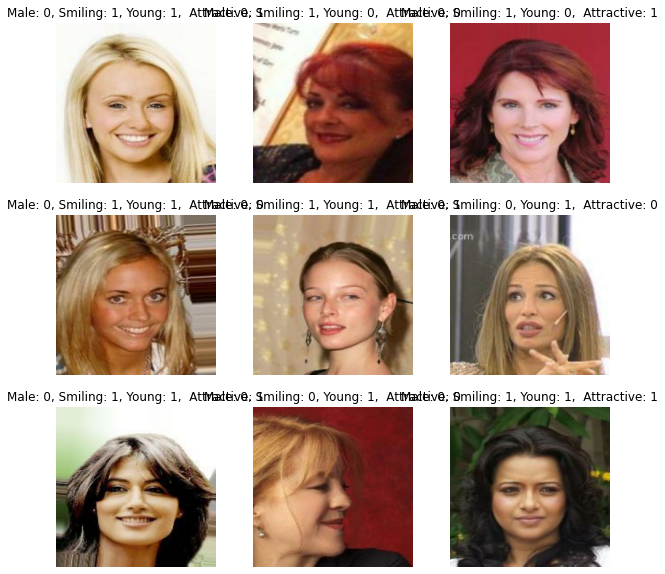

In [224]:
image, male, smiling, young, attractive = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[i].numpy().astype("uint8"))
    s = f"Male: {male[i].numpy()}, Smiling: {smiling[i].numpy()}, Young: {young[i].numpy()},  Attractive: {attractive[i].numpy()}"
    plt.title(s)
    plt.axis("off")

In [225]:
normalization_layer = tf.keras.layers.Rescaling(1. / 255)
preprocessing_model = tf.keras.Sequential([normalization_layer])
do_data_augmentation = False
if do_data_augmentation:
    preprocessing_model.add(tf.keras.layers.RandomRotation(0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomTranslation(0.2, 0))
    preprocessing_model.add(tf.keras.layers.RandomZoom(0.2, 0.2))
    preprocessing_model.add(tf.keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, male, smiling, young, attractive:
                        (preprocessing_model(images), (male, smiling, young, attractive)))

val_ds = val_ds.map(lambda images, male, smiling, young, attractive:
                    (normalization_layer(images), (male, smiling, young, attractive)))

In [226]:
do_fine_tuning = False
input = tf.keras.Input(shape=IMAGE_SIZE + (3,))
x = hub.KerasLayer(MODEL_HANDLE, trainable=do_fine_tuning)(input)
x = tf.keras.layers.Dropout(rate=0.2)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)

out_male = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='male')(x)
out_smiling = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='smiling')(x)
out_young = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='young')(x)
out_attractive = tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.0001), activation="sigmoid", name='attractive')(x)


model = tf.keras.Model( inputs = input, outputs = [out_male, out_smiling, out_young, out_attractive])
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 keras_layer_7 (KerasLayer)     (None, 1280)         5919312     ['input_9[0][0]']                
                                                                                                  
 dropout_7 (Dropout)            (None, 1280)         0           ['keras_layer_7[0][0]']          
                                                                                                  
 dense_7 (Dense)                (None, 128)          163968      ['dropout_7[0][0]']        

In [227]:
model.compile(
    loss = {
        "male": tf.keras.losses.BinaryCrossentropy(),
        "smiling": tf.keras.losses.BinaryCrossentropy(),
        "young": tf.keras.losses.BinaryCrossentropy(),
        "attractive": tf.keras.losses.BinaryCrossentropy()
    },
    metrics = {
        "male": 'accuracy',
        "smiling": 'accuracy',
        "young": 'accuracy',
        "attractive": 'accuracy'
    },
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [228]:
steps_per_epoch = len(train_df) // BATCH_SIZE
validation_steps = len(val_df) // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=100, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

Epoch 1/100
78/78 [==============================] - 662s 8s/step - loss: 1.6605 - male_loss: 0.2041 - smiling_loss: 0.5491 - young_loss: 0.3813 - attractive_loss: 0.5252 - male_accuracy: 0.9138 - smiling_accuracy: 0.7197 - young_accuracy: 0.8378 - attractive_accuracy: 0.7419 - val_loss: 1.3948 - val_male_loss: 0.1361 - val_smiling_loss: 0.4327 - val_young_loss: 0.3477 - val_attractive_loss: 0.4775 - val_male_accuracy: 0.9469 - val_smiling_accuracy: 0.7953 - val_young_accuracy: 0.8547 - val_attractive_accuracy: 0.7719
Epoch 2/100
78/78 [==============================] - 612s 8s/step - loss: 1.3406 - male_loss: 0.1349 - smiling_loss: 0.4297 - young_loss: 0.3268 - attractive_loss: 0.4485 - male_accuracy: 0.9492 - smiling_accuracy: 0.7996 - young_accuracy: 0.8622 - attractive_accuracy: 0.7925 - val_loss: 1.3707 - val_male_loss: 0.1201 - val_smiling_loss: 0.4159 - val_young_loss: 0.3540 - val_attractive_loss: 0.4799 - val_male_accuracy: 0.9510 - val_smiling_accuracy: 0.8052 - val_young_acc

Epoch 17/100
78/78 [==============================] - 600s 8s/step - loss: 0.8952 - male_loss: 0.0621 - smiling_loss: 0.2950 - young_loss: 0.2134 - attractive_loss: 0.3232 - male_accuracy: 0.9758 - smiling_accuracy: 0.8725 - young_accuracy: 0.9130 - attractive_accuracy: 0.8541 - val_loss: 1.3659 - val_male_loss: 0.1077 - val_smiling_loss: 0.3868 - val_young_loss: 0.3666 - val_attractive_loss: 0.5034 - val_male_accuracy: 0.9635 - val_smiling_accuracy: 0.8255 - val_young_accuracy: 0.8490 - val_attractive_accuracy: 0.7630
Epoch 18/100
78/78 [==============================] - 588s 8s/step - loss: 0.8735 - male_loss: 0.0594 - smiling_loss: 0.2815 - young_loss: 0.2102 - attractive_loss: 0.3210 - male_accuracy: 0.9788 - smiling_accuracy: 0.8772 - young_accuracy: 0.9156 - attractive_accuracy: 0.8568 - val_loss: 1.3737 - val_male_loss: 0.1112 - val_smiling_loss: 0.3812 - val_young_loss: 0.3760 - val_attractive_loss: 0.5038 - val_male_accuracy: 0.9609 - val_smiling_accuracy: 0.8313 - val_young_a

Epoch 33/100
78/78 [==============================] - 516s 7s/step - loss: 0.5765 - male_loss: 0.0321 - smiling_loss: 0.2033 - young_loss: 0.1294 - attractive_loss: 0.2087 - male_accuracy: 0.9878 - smiling_accuracy: 0.9155 - young_accuracy: 0.9505 - attractive_accuracy: 0.9190 - val_loss: 1.6534 - val_male_loss: 0.1282 - val_smiling_loss: 0.4289 - val_young_loss: 0.4912 - val_attractive_loss: 0.6020 - val_male_accuracy: 0.9594 - val_smiling_accuracy: 0.8125 - val_young_accuracy: 0.8448 - val_attractive_accuracy: 0.7490
Epoch 34/100
78/78 [==============================] - 526s 7s/step - loss: 0.5731 - male_loss: 0.0339 - smiling_loss: 0.1945 - young_loss: 0.1353 - attractive_loss: 0.2064 - male_accuracy: 0.9879 - smiling_accuracy: 0.9230 - young_accuracy: 0.9473 - attractive_accuracy: 0.9187 - val_loss: 1.6363 - val_male_loss: 0.1329 - val_smiling_loss: 0.4422 - val_young_loss: 0.4631 - val_attractive_loss: 0.5950 - val_male_accuracy: 0.9594 - val_smiling_accuracy: 0.8172 - val_young_a

Epoch 49/100
78/78 [==============================] - 534s 7s/step - loss: 0.3962 - male_loss: 0.0213 - smiling_loss: 0.1411 - young_loss: 0.0895 - attractive_loss: 0.1398 - male_accuracy: 0.9936 - smiling_accuracy: 0.9452 - young_accuracy: 0.9678 - attractive_accuracy: 0.9469 - val_loss: 1.9214 - val_male_loss: 0.1537 - val_smiling_loss: 0.5044 - val_young_loss: 0.5665 - val_attractive_loss: 0.6923 - val_male_accuracy: 0.9547 - val_smiling_accuracy: 0.8083 - val_young_accuracy: 0.8297 - val_attractive_accuracy: 0.7531
Epoch 50/100
78/78 [==============================] - 544s 7s/step - loss: 0.4071 - male_loss: 0.0209 - smiling_loss: 0.1451 - young_loss: 0.0949 - attractive_loss: 0.1415 - male_accuracy: 0.9945 - smiling_accuracy: 0.9441 - young_accuracy: 0.9656 - attractive_accuracy: 0.9454 - val_loss: 1.9200 - val_male_loss: 0.1438 - val_smiling_loss: 0.5180 - val_young_loss: 0.5271 - val_attractive_loss: 0.7264 - val_male_accuracy: 0.9568 - val_smiling_accuracy: 0.8109 - val_young_a

KeyboardInterrupt: 

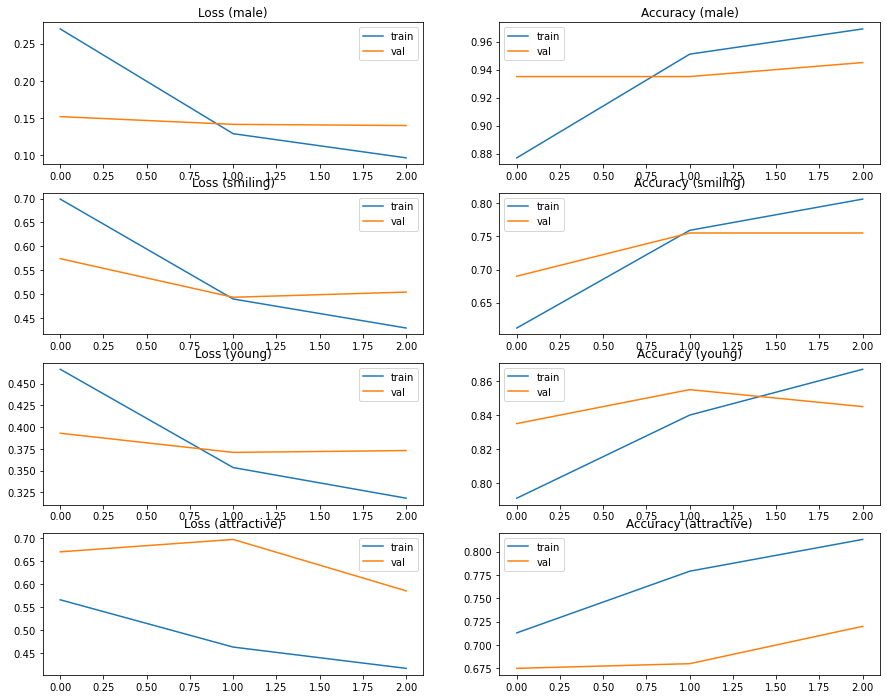

In [229]:
fig, ax = plt.subplots(4, 2, figsize=(15, 12))
for i, c in enumerate(["male", "smiling", "young", "attractive"]):
    ax[i, 0].plot(hist[f"{c}_loss"], label="train")
    ax[i, 0].plot(hist[f"val_{c}_loss"], label="val")
    ax[i, 0].set_title(f"Loss ({c})")
    ax[i, 0].legend()
    ax[i, 1].plot(hist[f"{c}_accuracy"], label="train")
    ax[i, 1].plot(hist[f"val_{c}_accuracy"], label="val")
    ax[i, 1].set_title(f"Accuracy ({c})")
    ax[i, 1].legend()
plt.show()

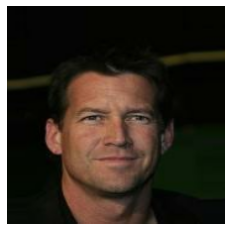

1/1 [==============================] - 1s 1000ms/step
Male: actual 1, predicted 1 (1.0000)
Smiling: actual 0, predicted 1 (0.8234)
Young: actual 0, predicted 1 (0.9630)
Attractive: actual 1, predicted 0 (0.2937)


In [230]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
plt.imshow(image)
plt.axis('off')
plt.show()

prediction_scores = model.predict(np.expand_dims(image, axis=0))
for i, label in enumerate(["Male", "Smiling", "Young", "Attractive"]):
    pred = prediction_scores[i][0][0]
    print(f"{label}: actual {y[i][0]}, predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})")

In [231]:
#from keras.utils import plot_model
#model.summary()
x, y = next(iter(val_ds))
image = x[0, :, :, :]
image

<tf.Tensor: shape=(220, 220, 3), dtype=float32, numpy=
array([[[0.54509807, 0.72156864, 0.8745099 ],
        [0.54509807, 0.72156864, 0.8745099 ],
        [0.54509807, 0.72156864, 0.8745099 ],
        ...,
        [0.55891263, 0.73743314, 0.8801249 ],
        [0.5568628 , 0.73333335, 0.8862746 ],
        [0.5568628 , 0.73333335, 0.8862746 ]],

       [[0.54509807, 0.72156864, 0.8745099 ],
        [0.54509807, 0.72156864, 0.8745099 ],
        [0.54509807, 0.72156864, 0.8745099 ],
        ...,
        [0.55891263, 0.73743314, 0.8801249 ],
        [0.5568628 , 0.73333335, 0.8862746 ],
        [0.5568628 , 0.73333335, 0.8862746 ]],

       [[0.54509807, 0.72156864, 0.8745099 ],
        [0.54509807, 0.72156864, 0.8745099 ],
        [0.54509807, 0.72156864, 0.8745099 ],
        ...,
        [0.55891263, 0.73743314, 0.8801249 ],
        [0.5568628 , 0.73333335, 0.8862746 ],
        [0.5568628 , 0.73333335, 0.8862746 ]],

       ...,

       [[0.956952  , 0.93342257, 0.88636374],
        [0.95

In [232]:
def open_images(inference_folder: str) -> np.ndarray:
    """Loads images from a folder and prepare them for inferencing.

    Parameters
    ----------
    inference_folder : str
        Location of images for inferencing.

    Returns
    -------
    np.ndarray
        List of images as numpy arrays transformed to fit the efficient_net model input specs.
    """
    images = []
    for img in os.listdir(inference_folder):
        img_location = os.path.join(inference_folder, img)  # create full path to image

        with Image.open(img_location) as img:  # open image with pillow

            img = np.array(img)
            img = img[:, :, :3]
            img = np.expand_dims(img, axis=0)  # add 0 dimension to fit input shape of efficient_net

        images.append(img)
    images_array = np.vstack(images)  # combine images efficiently to a numpy array
    return images_array

In [255]:
from PIL import Image
import os, sys

path = "./image_samples/"
dirs = os.listdir( path )
resized_path = "./images_resized/"

def resize():
    for item in dirs:
        print(item)
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            im = im.convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((220,220), Image.ANTIALIAS)
            imResize.save(resized_path + item + '_resized.jpg', 'JPEG', quality=90)
            #imResize.save(resized_path + '_resized.jpg', 'JPEG', quality=90)

resize()

jean.jpg
nada.jpg
souhail.jpg


In [284]:
def display_image(image,s):
    plt.imshow(image)
    plt.title(s)
    plt.figure()

In [282]:
def image_prediction(prediction_score):
    s = ""
    for i, label in enumerate(["Male", "Smiling", "Young", "Attractive"]):
        pred = prediction_score[i][0][0]
        s += f"{label}: predicted {1 if pred > 0.5 else 0} ({format(pred, '.4f')})"
        s +="\n"
    return s  

1/1 [==============================] - 0s 232ms/step


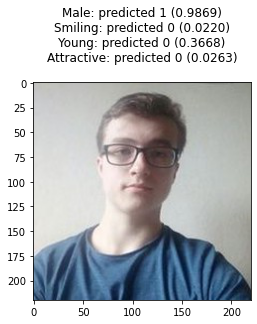

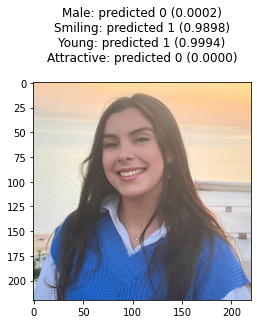

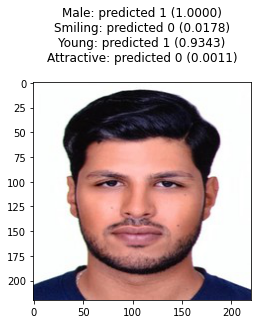

<Figure size 432x288 with 0 Axes>

In [283]:
import os
from PIL import Image
images = open_images(resized_path)
c=0
for image in images:
    prediction_score= model.predict(np.expand_dims(image * 10e-4, axis=0))
    s = image_prediction(prediction_score)
    display_image(image,s)



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
img = keras.preprocessing.image.load_img(
    resized_path+"jean.jpg_resized.jpg", target_size=IMAGE_SIZE
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
img_array
predictions = model.predict(img_array)
predictions

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as pl


img_path = resized_path+"jean.jpg_resized.jpg"
plt.imshow(img)
plt.show()

img = image.load_img(img_path, target_size=(220, 220))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)
#model = tf.keras.applications.resnet50.ResNet50()
prediction = model.predict(img_preprocessed)
for item in prediction: print(item)